# **Week 6 Assignment**

Changing Data Distribution and seeing impact on Model Metrics and Visualizing Outcomes. </br>
**Datasets:**
1. Online multicategory store data
2. Mall customer data

Amalgamating the 2 datasets on column: **Spending Score** </br>
Feature chosen for changing data distribution: 
1. **event_type**
2. **Spending_Score**


# **Installations and Data collection**

In [ ]:
!pip install shap

In [ ]:
#Importing data from google sheets - multicategory dataset
import warnings
warnings.filterwarnings('ignore')
from io import BytesIO
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import seaborn as sns
import tensorflow.compat.v1 as tf
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vTrfrhv1SOGSa0cLry-16Tx4ykJZBRDDjtCCJJzai0OtB8ewYbmzcSyNBSqvARAqHppa_NM1LH1-MEC/pub?gid=1654498000&single=true&output=csv')
data = r.content
df_Oct = pd.read_csv(BytesIO(data), nrows=5000)
df_Oct = df_Oct.drop(columns='Unnamed: 0', axis=1)

In [ ]:
##Importing the mall customer dataset
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vT0HMaqAgd7d_EyMRByWkVp8JM7jmp_969OPyfDMsk4pHpdWjPeQQePP0Rrfm4bwWxQVh7lJPPZHJvi/pub?gid=0&single=true&output=csv')
data = r.content
df_Mall = pd.read_csv(BytesIO(data))

In [ ]:
df_Oct.head(3)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,total_spending,Spending_Score
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,71.58,6
1,2019-10-01 00:00:15 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,71.58,6
2,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,277.56,25


In [ ]:
df_Mall.head(3)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


# **Pre-processing**

### **Amalgamating the two datasets**

In [ ]:
## We are calculating the total amount spent by each customer on electronice data.
df1 = df_Oct.groupby(['user_id']).agg({'price': 'sum'}).reset_index()

In [ ]:
##Renaming the columns
df1.columns = ['user_id','total_spending']
df1.head(3)

,user_id,total_spending
0,306441847,164.71
1,400972610,162.25
2,442188017,313.93


In [ ]:
df1.shape

(1747, 2)

In [ ]:
#Join the df_Oct df with the df1 df 
df_Oct = df_Oct.merge(df1,on='user_id')

In [ ]:
df_Oct.shape

(5000, 10)

In [ ]:
##Calculating spending score to merge with mall customer dataset: Scaling down column 'total_spending'
df_Oct['Spending_Score'] = pd.qcut(df_Oct['total_spending'], q=100, labels=False)

In [ ]:
len(df_Oct['Spending_Score'].unique())

100

In [ ]:
##Dropping the columns not needed for merge
df_Mall = df_Mall.drop(columns=['CustomerID','Annual Income (k$)'])

In [ ]:
df_Mall.columns = ['Gender','Age','Spending_Score']
df_Mall.head(3)

,Gender,Age,Spending_Score
0,Male,19,39
1,Male,21,81
2,Female,20,6


In [ ]:
amalgamated_df = df_Oct.merge(df_Mall,on=['Spending_Score'])
amalgamated_df.head(3)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,total_spending,Spending_Score,Gender,Age
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,71.58,6,Female,20
1,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,71.58,6,Female,35
2,2019-10-01 00:00:15 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,71.58,6,Female,20


In [ ]:
amalgamated_df.shape

(9931, 13)

### **converting categorical to numeric data**

In [ ]:
##Checking for null values
amalgamated_df.isnull().sum()

event_time           0
event_type           0
product_id           0
category_id          0
category_code     3004
brand             1308
price                0
user_id              0
user_session         0
total_spending       0
Spending_Score       0
Gender               0
Age                  0
dtype: int64

In [ ]:
##Taking care of the null values in the dataset
amalgamated_df.dropna(inplace=True)

In [ ]:
amalgamated_df.isnull().sum()

event_time        0
event_type        0
product_id        0
category_id       0
category_code     0
brand             0
price             0
user_id           0
user_session      0
total_spending    0
Spending_Score    0
Gender            0
Age               0
dtype: int64

In [ ]:
amalgamated_df.shape

(6469, 13)

In [ ]:
##Column: gender convert to numeric
amalgamated_df['Gender'].replace({
    'Male': 0,
    'Female': 1
}, inplace=True)

In [ ]:
##Column: brand convert to numeric
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
amalgamated_df['brand'] = le.fit_transform(amalgamated_df.brand.values)

In [ ]:
###Column: event_type convert to numeric
amalgamated_df['event_type'].replace({
    'view': 0,
    'cart': 0,
    'purchase': 1
}, inplace=True)

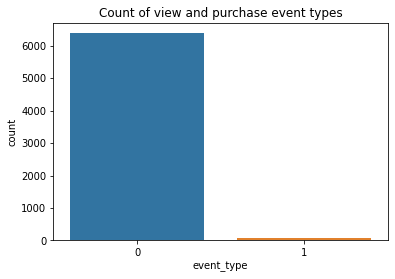

In [ ]:
plt.title('Count of view and purchase event types')
sns.countplot(x = 'event_type', data = amalgamated_df)

# **SHAP**
To understand feature importance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
# The target variable is 'quality'.
Y = amalgamated_df['event_type']
X =  amalgamated_df[['product_id', 'category_id', 'Age','Gender', 'brand','price','Spending_Score']]
# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
# Build the model with the random forest regression algorithm:
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

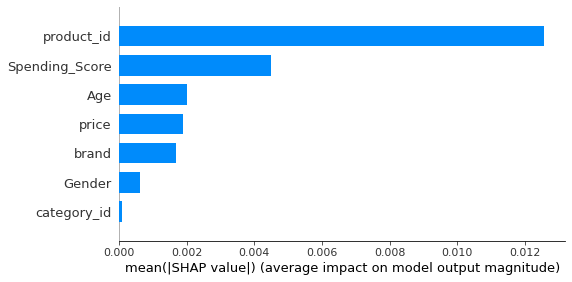

In [ ]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

# **Muller loop helper function**

In [ ]:
#Importing required libraries
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [ ]:
##Function top plot roc graph
def roc_auc_graph(df_roc, clf_best, max_class):
  X = df_roc[['product_id', 'Age', 'brand','price', 'Spending_Score']]
  y = df_roc[['event_type']]
  X = StandardScaler().fit_transform(X)
  # split into train/test sets
  trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
  # generate a no skill prediction (majority class)
  ns_probs = [0 for _ in range(len(testy))]
  # fit a model
  model = clf_best
  # model.fit(trainX, trainy)
  # predict probabilities
  lr_probs = model.predict_proba(testX)
  # keep probabilities for the positive outcome only
  lr_probs = lr_probs[:, 1]
  # calculate scores
  ns_auc = roc_auc_score(testy, ns_probs)
  lr_auc = roc_auc_score(testy, lr_probs)
  # summarize scores
  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print(max_class+': ROC AUC=%.3f' % (lr_auc))
  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
  # plot the roc curve for the model
  pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  pyplot.plot(lr_fpr, lr_tpr, marker='.', label=max_class)
  # axis labels
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  # show the legend
  pyplot.legend()
  # show the plot
  pyplot.show()

In [ ]:
def calc_F1_Score(df_fscore, clf_best, max_class):
  X = df_fscore[['product_id', 'Age', 'brand','price', 'Spending_Score']]
  y = df_fscore[['event_type']]
  X = StandardScaler().fit_transform(X)
  # split into train/test sets
  trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

  model = clf_best
#  model.fit(trainX, trainy)
  # generate data
  trainX, trainy, testX, testy = get_data()
  # fit model
  model = get_model(trainX, trainy)

  yhat_probs = model.predict(testX)
  # predict crisp classes for test set
  yhat_classes = model.predict_classes(testX)
  yhat_probs = yhat_probs[:, 0]
  yhat_classes = yhat_classes[:, 0]
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(testy, yhat_classes)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(testy, yhat_classes)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(testy, yhat_classes)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(testy, yhat_classes)
  print('F1 score: %f' % f1)

In [ ]:
def muller_loop(muller_df):
  df_compare_muller = pd.DataFrame(columns=['Classifier','Accuracy/Score', 'Training Time'])
  import time as time
  import xgboost as xgb
  names = ["XGBoost","MLP","Random Forest", "Nearest Neighbors"]

  classifiers = [
      xgb.XGBClassifier(max_depth=5, learning_rate=0.1,n_jobs=-1),
      MLPClassifier(),
      RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
      KNeighborsClassifier(2)]

  X = muller_df[['product_id', 'Age', 'brand','price', 'Spending_Score']]
  y = muller_df[['event_type']]
  X = StandardScaler().fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

  max_score = 0.0
  max_class = ''
  clf_best = ""
  model = ""
  # iterate over classifiers
  for name, clf in zip(names, classifiers):
      start_time = time.time()
      clf.fit(X_train, y_train)
      score = 100.0 * clf.score(X_test, y_test)
      print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))
      training_time = time.time() - start_time
      df_compare_muller.loc[-1] = [name, score, training_time]  # adding a row
      df_compare_muller.index = df_compare_muller.index + 1  # shifting index
      df_compare_muller = df_compare_muller.sort_index()

      if score > max_score:
          clf_best = clf
          max_score = score
          max_class = name
  print(df_compare_muller)
  print(80*'-' )
  print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
  print(80*'-' )
  print('Printing the confusion matrix for'+max_class)
  plot_confusion_matrix(clf_best, X_test, y_test, values_format=".1f", cmap=plt.cm.Reds)  
  plt.show()

  y_pred = clf_best.predict(X_test)
  print('Printing the Classification report for'+max_class)
  print(80*'-' )
  print(classification_report(y_test, y_pred))
  print('Printing the ROC graph for'+max_class)
  print(80*'-' )
  roc_auc_graph(muller_df, clf_best,max_class)
  # calc_F1_Score(muller_df, clf_best,max_class)
  return df_compare_muller


Classifier = XGBoost, Score (test, accuracy) = 98.53, Training time = 0.26 seconds
Classifier = MLP, Score (test, accuracy) = 98.53, Training time = 5.22 seconds
Classifier = Random Forest, Score (test, accuracy) = 98.53, Training time = 0.05 seconds
Classifier = Nearest Neighbors, Score (test, accuracy) = 98.53, Training time = 0.07 seconds
          Classifier  Accuracy/Score  Training Time
0  Nearest Neighbors       98.531685       0.072752
1      Random Forest       98.531685       0.049579
2                MLP       98.531685       5.218534
3            XGBoost       98.531685       0.257756
--------------------------------------------------------------------------------
Best --> Classifier = XGBoost, Score (test, accuracy) = 98.53
--------------------------------------------------------------------------------
Printing the confusion matrix forXGBoost


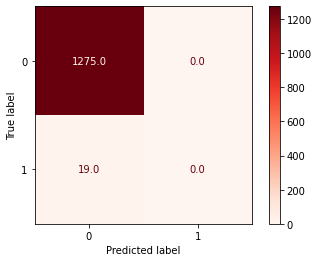

Printing the Classification report forXGBoost
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1275
           1       0.00      0.00      0.00        19

    accuracy                           0.99      1294
   macro avg       0.49      0.50      0.50      1294
weighted avg       0.97      0.99      0.98      1294

Printing the ROC graph forXGBoost
--------------------------------------------------------------------------------
No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.971


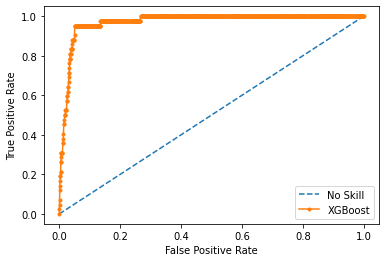

In [ ]:
##Muller loop on original imbalanced data
df_comp = muller_loop(amalgamated_df)

In [ ]:
df_comp

,Classifier,Accuracy/Score,Training Time
0,Nearest Neighbors,98.377125,0.070798
1,Random Forest,98.377125,0.050806
2,MLP,98.377125,3.429319
3,XGBoost,98.377125,0.246650


# **Balancing the target data using SMOTE**

In [ ]:
##Balancing the target column using SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(amalgamated_df[['product_id', 'category_id', 'Age','Gender', 'brand','price', 'Spending_Score']], amalgamated_df['event_type'])

In [ ]:
##Convert to df
df_features = pd.DataFrame(X_res, columns = ['product_id', 'category_id', 'Spending_Score', 'Age','Gender', 'brand','price'])
df_label = pd.DataFrame(y_res, columns = ['event_type'])

In [ ]:
##Merging the 2 df - df_features and df_label
df_features['event_type'] = df_label['event_type'].values
new_df = df_features

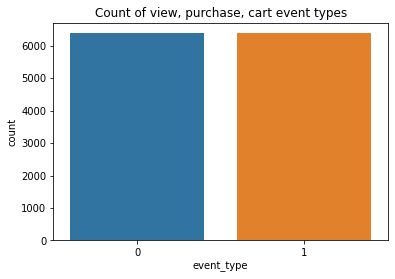

In [ ]:
##Check if the target variable is balanced
plt.title('Count of view, purchase, cart event types')
sns.countplot(x = 'event_type', data = new_df)

# **Muller loop on balanced (event-type) data**

Classifier = XGBoost, Score (test, accuracy) = 95.93, Training time = 0.54 seconds
Classifier = MLP, Score (test, accuracy) = 86.34, Training time = 11.06 seconds
Classifier = Random Forest, Score (test, accuracy) = 84.93, Training time = 0.08 seconds
Classifier = Nearest Neighbors, Score (test, accuracy) = 95.58, Training time = 0.10 seconds
          Classifier  Accuracy/Score  Training Time
0  Nearest Neighbors       95.575568       0.105255
1      Random Forest       84.925607       0.076856
2                MLP       86.335161      11.064706
3            XGBoost       95.927956       0.544462
--------------------------------------------------------------------------------
Best --> Classifier = XGBoost, Score (test, accuracy) = 95.93
--------------------------------------------------------------------------------
Printing the confusion matrix forXGBoost


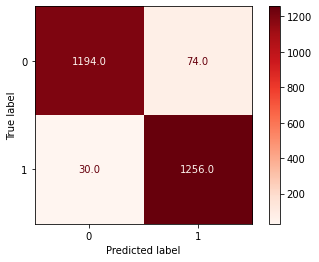

Printing the Classification report forXGBoost
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1268
           1       0.94      0.98      0.96      1286

    accuracy                           0.96      2554
   macro avg       0.96      0.96      0.96      2554
weighted avg       0.96      0.96      0.96      2554

Printing the ROC graph forXGBoost
--------------------------------------------------------------------------------
No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.989


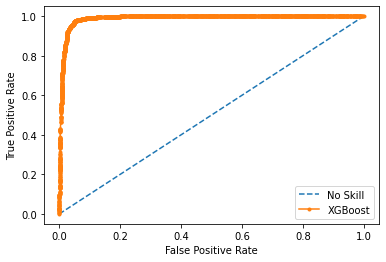

,Classifier,Accuracy/Score,Training Time
0,Nearest Neighbors,95.575568,0.105255
1,Random Forest,84.925607,0.076856
2,MLP,86.335161,11.064706
3,XGBoost,95.927956,0.544462


In [ ]:
muller_loop(new_df)

# **Upsampling and downsampling**


### **Upsampling**

In [ ]:
##Converting the column values into the required datatypes
new_df['Age'] = new_df['Age'].astype(int) 
new_df['Gender'] = new_df['Gender'].astype(int) 
new_df['brand'] = new_df['brand'].astype(int) 
new_df['event_type'] = new_df['event_type'].astype(int)
new_df['Spending_Score'] = new_df['Spending_Score'].astype(int) 

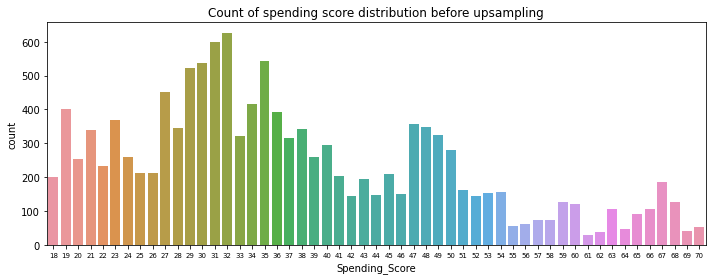

In [ ]:
plt.figure(figsize=(10,4)) # this creates a figure 8 inch wide, 4 inch high
plt.title('Count of spending score distribution before upsampling')
ax = sns.countplot(x = 'Spending_Score', data = new_df)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.tight_layout()
plt.show()

In [ ]:
##SMOTE to upsample spending_score
sm = SMOTE(random_state=42)
X_res_up, y_res_up = sm.fit_resample(new_df[['product_id', 'category_id', 'Age','Gender', 'brand','price', 'event_type']], new_df['Spending_Score'])


In [ ]:
##Converting to df
df1_up = pd.DataFrame(X_res_up, columns = ['product_id', 'category_id', 'Age','Gender', 'brand','price', 'event_type'])
df2_up = pd.DataFrame(y_res_up, columns = ['Spending_Score'])

In [ ]:
df1_up['Spending_Score'] = df2_up['Spending_Score'].values

In [ ]:
upsampled_df = df1_up

In [ ]:
upsampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33178 entries, 0 to 33177
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      33178 non-null  float64
 1   category_id     33178 non-null  float64
 2   Age             33178 non-null  float64
 3   Gender          33178 non-null  float64
 4   brand           33178 non-null  float64
 5   price           33178 non-null  float64
 6   event_type      33178 non-null  float64
 7   Spending_Score  33178 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 2.0 MB


In [ ]:
##Converting the column values into the required datatypes
upsampled_df['Age'] = upsampled_df['Age'].astype(int) 
upsampled_df['Gender'] = upsampled_df['Gender'].astype(int) 
upsampled_df['brand'] = upsampled_df['brand'].astype(int) 
upsampled_df['event_type'] = upsampled_df['event_type'].astype(int)
upsampled_df['Spending_Score'] = upsampled_df['Spending_Score'].astype(int) 

In [ ]:
upsampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33178 entries, 0 to 33177
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      33178 non-null  float64
 1   category_id     33178 non-null  float64
 2   Age             33178 non-null  int64  
 3   Gender          33178 non-null  int64  
 4   brand           33178 non-null  int64  
 5   price           33178 non-null  float64
 6   event_type      33178 non-null  int64  
 7   Spending_Score  33178 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 2.0 MB


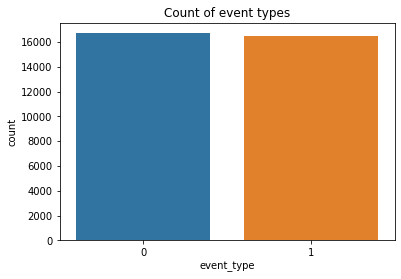

In [ ]:
plt.title('Count of event types')
sns.countplot(x = 'event_type', data = upsampled_df)

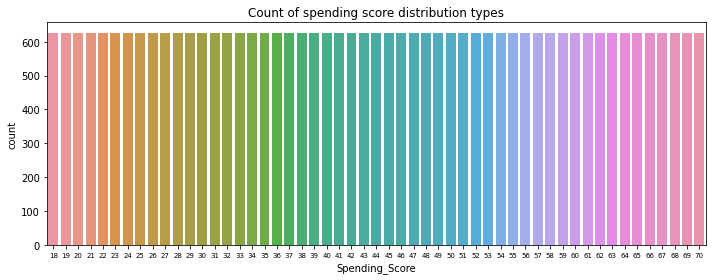

In [ ]:
plt.figure(figsize=(10,4)) # this creates a figure 8 inch wide, 4 inch high
plt.title('Count of spending score distribution types')
ax = sns.countplot(x = 'Spending_Score', data = upsampled_df)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.tight_layout()
plt.show()

### **Downsampling**

In [ ]:
##Downsampling 'Spending_Score' using CondensedNearestNeighbour
from imblearn.under_sampling import CondensedNearestNeighbour
undersample = CondensedNearestNeighbour(n_neighbors=1)
X_res_down, y_res_down = undersample.fit_resample(new_df[['product_id', 'category_id', 'Age','Gender', 'brand','price', 'event_type']], new_df['Spending_Score'])


In [ ]:
#Convert to df
df1_down = pd.DataFrame(X_res_down, columns = ['product_id', 'category_id', 'Age','Gender', 'brand','price', 'event_type'])
df2_down = pd.DataFrame(y_res_down, columns = ['Spending_Score'])

In [ ]:
##Merge the 2 df together
df1_down['Spending_Score'] = df2_down['Spending_Score'].values

In [ ]:
downsampled_df = df1_down

In [ ]:
downsampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250 entries, 0 to 2249
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      2250 non-null   float64
 1   category_id     2250 non-null   float64
 2   Age             2250 non-null   float64
 3   Gender          2250 non-null   float64
 4   brand           2250 non-null   float64
 5   price           2250 non-null   float64
 6   event_type      2250 non-null   float64
 7   Spending_Score  2250 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 140.8 KB


In [ ]:
##Converting the column values into the required datatypes
downsampled_df['Age'] = downsampled_df['Age'].astype(int) 
downsampled_df['Gender'] = downsampled_df['Gender'].astype(int) 
downsampled_df['brand'] = downsampled_df['brand'].astype(int) 
downsampled_df['event_type'] = downsampled_df['event_type'].astype(int)
downsampled_df['Spending_Score'] = downsampled_df['Spending_Score'].astype(int) 

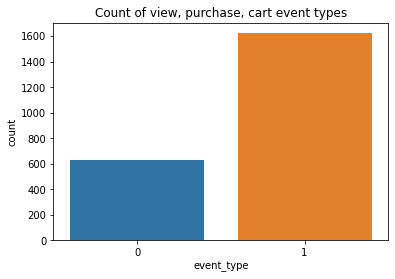

In [ ]:
plt.title('Count of view, purchase, cart event types')
sns.countplot(x = 'event_type', data = downsampled_df)

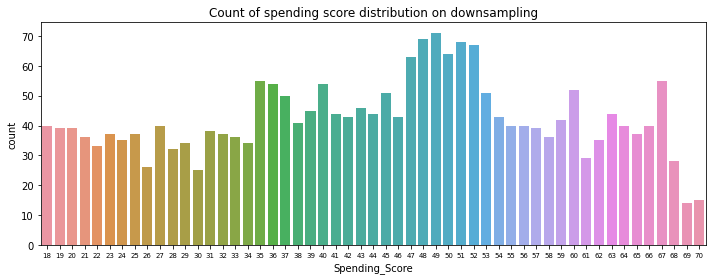

In [ ]:
plt.figure(figsize=(10,4)) # this creates a figure 8 inch wide, 4 inch high
plt.title('Count of spending score distribution on downsampling')
ax = sns.countplot(x = 'Spending_Score', data = downsampled_df)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.tight_layout()
plt.show()

# **Slider**

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
## Defining slider here.
def f(spending_score):
  if (spending_score == 1):
    print("Do nothing")
  elif (spending_score == 2):
    print ("Running muller loop on upsampled data set. We upsampled on Spending Score")
    df_compare = muller_loop(new_df_2)
    print(df_compare)
  else:
    print ("Running muller loop on downsampled data set. We downsampled on Spending Score")
    df_compare = muller_loop(downsampled_df)
    print(df_compare)

In [ ]:
interact(f, spending_score=(0,2));

interactive(children=(IntSlider(value=1, description='spending_score', max=2), Output()), _dom_classes=('widge…